# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [31]:
import pandas as pd
import numpy as np

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)


assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

# Part 1:

In [3]:
!pip install category_encoders

  Using cached https://files.pythonhosted.org/packages/f7/d3/82a4b85a87ece114f6d0139d643580c726efa45fa4db3b81aed38c0156c5/category_encoders-1.3.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install pdpbox

    100% |████████████████████████████████| 57.7MB 909kB/s eta 0:00:01
    100% |████████████████████████████████| 286kB 42.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for pdpbox ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 25.3MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [59]:
!pip install yellowbrick

  Using cached https://files.pythonhosted.org/packages/d8/e8/125204ea84a7424a3237556e8dfaec9fee21f2e3d5b3695eb9ce355bf668/yellowbrick-0.9.1-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [54]:
# Getting the tools
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder

rseed = 42

In [32]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51916 entries, 0 to 51915
Data columns (total 17 columns):
Inspection ID      51916 non-null int64
DBA Name           51916 non-null object
AKA Name           51293 non-null object
License #          51911 non-null float64
Facility Type      51692 non-null object
Risk               51904 non-null object
Address            51916 non-null object
City               51863 non-null object
State              51906 non-null object
Zip                51890 non-null float64
Inspection Date    51916 non-null object
Inspection Type    51915 non-null object
Violations         42261 non-null object
Latitude           51718 non-null float64
Longitude          51718 non-null float64
Location           51718 non-null object
Fail               51916 non-null int64
dtypes: float64(4), int64(2), object(11)
memory usage: 6.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17306 entries, 0 to 17305
Data columns (total 17 columns):
Inspection ID      1

(None, None)

In [26]:
def missing_values(data):
    total = data.isnull().sum()
    percent = data.isnull().sum().sort_values(ascending = False)/len(data)*100
    tp = pd.concat([total, percent], axis=1, keys=['Total', '%'])
    return(np.transpose(tp))

In [27]:
missing_values(train)

,AKA Name,Address,City,DBA Name,Facility Type,Fail,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Risk,State,Violations,Zip
Total,623.000000,0.0,53.000000,0.0,224.000000,0.0,0.0,0.0,1.000000,198.000000,5.000000,198.000000,198.000000,12.000000,10.000000,9655.00000,26.000000
%,1.200015,0.0,0.102088,0.0,0.431466,0.0,0.0,0.0,0.001926,0.381385,0.009631,0.381385,0.381385,0.023114,0.019262,18.59735,0.050081


In [30]:
missing_values(test)

,AKA Name,Address,City,DBA Name,Facility Type,Fail,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Risk,State,Violations,Zip
Total,222.000000,0.0,18.00000,0.0,87.000000,0.0,0.0,0.0,0.0,61.000000,2.000000,61.000000,61.000000,7.000000,2.000000,3280.000000,8.000000
%,1.282792,0.0,0.10401,0.0,0.502716,0.0,0.0,0.0,0.0,0.352479,0.011557,0.352479,0.352479,0.040448,0.011557,18.952964,0.046227


Right off the bat we can safely assume it'll be a good idea to drop the following:

Inspection ID
DBA Name*
AKA Name*
License #
Address
State (IL)
Location
Long, Lat 

Going to Categorically Encode the following:
    Risk
    Facility Type
    Risk
    City
    ZIP (may be duplicate of City, TBD)
    Inspection Type

It stands to reason that 'Violations' will have an impact on our target variable

In [46]:
def wrangle_data(df):
    
    df = df.copy()
    # dropping columns we don't need
    df = df.drop(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Address',
                 'State','Location', 'Longitude', 'Latitude'], axis=1)
    
    # New feature for younger facilities
    df['sub_2_yrs'] = df['Facility Type'].str.lower().str.contains('under 2 years')
    df['sub_2_yrs'] = df['sub_2_yrs'].fillna(False)
    
    # Formatting for Categorical Encoding later
    ce_feats = ['Risk', 'Facility Type', 'City', 'Inspection Type']
    for f in ce_feats:
        df[f] = df[f].str.lower()
        
    # Filling missing values
    df['Risk'] = df['Risk'].fillna('Unknown')
    df['Facility Type'] = df['Facility Type'].fillna('Unknown')
    df['City'] = df['City'].fillna('chicago')
    df['Zip'] = df['Zip'].fillna(0)
    df['Inspection Type'] = df['Inspection Type'].fillna('Unknown')
    
    # Date-Time conversion
    df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
    df['inspection_Day'] = df['Inspection Date'].dt.day
    df['inspection_Mo'] = df['Inspection Date'].dt.month
    df['inspection_YR'] = df['Inspection Date'].dt.year
    df = df.drop('Inspection Date', axis=1)
    
    # New feature for # of Violations
    df['Violations_Count'] = df['Violations'].str.count('\|') + 1
    df['Violations_Count'] = df['Violations_Count'].fillna(0)
    
    # Dropping Violations bc it's an inconvertible string
    df = df.drop('Violations', axis = 1)

    
    return df
    

In [47]:
# Wrangling the DF's

w_train = wrangle_data(train)
w_test = wrangle_data(test)

In [48]:
# Categorical Encoding


categorical_enc = ce.OrdinalEncoder(cols=['Risk', 'Facility Type', 'City', 'Inspection Type'])
w_train = categorical_enc.fit_transform(w_train)
w_test = categorical_enc.transform(w_test)

In [49]:
# Checking our work
w_train.head()

,Facility Type,Risk,City,Zip,Inspection Type,Fail,sub_2_yrs,inspection_Day,inspection_Mo,inspection_YR,Violations_Count
0,1,1,1,60657.0,1,1,False,15,9,2017,5.0
1,2,2,1,60636.0,2,0,False,20,10,2011,7.0
2,1,1,1,60649.0,3,0,False,5,4,2016,1.0
3,1,3,1,60632.0,1,0,False,29,4,2016,2.0
4,3,1,1,60629.0,1,0,False,10,1,2011,3.0


# Part 2: 

In [51]:
# Going to use GBC because ¯\_(ツ)_/¯
target = 'Fail'

X_train = w_train.drop([target], axis=1)
y_train = w_train[target]
X_test = w_test.drop(target, axis=1)
y_test = w_test[target]

# CV Score:
gbc = GradientBoostingClassifier()
cross_val_score(gbc, X_train, y_train, scoring='roc_auc', n_jobs=-1)


array([0.84241393, 0.84848602, 0.83739406])

In [53]:
# Let's see what the test set has to say about all that:

gbc.fit(X_train, y_train)
y_test_probabilities = gbc.predict_proba(X_test)


# score
roc_auc_score(y_test, y_test_probabilities[:,1])

0.8411253732993897

Pretty damn good. If we wanted to take another stab at it I think it might be useful to run more analysis on the violations or engineer some more features to surface more patterns. 

# Part 3: 

Let's visualize which Feature Importance:

In [64]:
from yellowbrick.features.importances import FeatureImportances

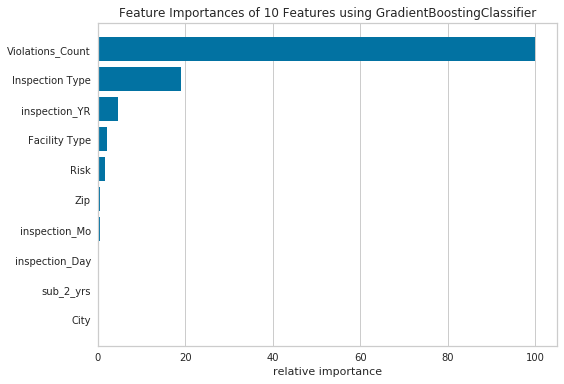

In [65]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(X_train, y_train)
viz.poof()